In [1]:
import cv2 as cv
import numpy as np
import random
import math
import time
from matplotlib import pyplot as plt

In [2]:
global CannyPara
global RANSACIterationN,RANSACe1,RANSACThresholdRatio

CannyPara = [150,500]

RANSACIterationN = 10000
RANSACThresholdRatio = 0.7
RANSACe1 = 1

#performace
global pBarLength

pBarLength = 30

In [3]:
def EdgeExtraction(t1, t2, img): #Perform Canny Edge Detection
    imgGray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    imgGaussian = cv.GaussianBlur(imgGray,(3,3),10)
    imgCanny = cv.Canny(imgGaussian,t1,t2)

    # plt
    # plt.subplot(2,1,1)
    # plt.imshow(imgCanny,cmap="gray")
    # plt.title("Edge Image")
    return imgCanny

In [4]:
def RandomPointsGenerate(validPoints,imgSize): #select 3 point according to the edge image
    points = []
    #obtain 3 point from validPoint
    points = random.sample(validPoints,3)

    
    if CollinearityCheck(points) and points != None:
        return points
    else:
        # print("\nWarning: redo random point generation")
        return RandomPointsGenerate(validPoints,imgSize)

In [5]:
def CollinearityCheck(points): #Accoridng to 3 point to check the collinearent of them
    isCollinearent = False    
    # print(points)
    #(y3−y1)(x2−x1)−(y2−y1)(x3−x1)=0 
    temp = (points[2][1] - points[0][1])*(points[1][0] - points[0][0]) - (points[1][1]-points[0][1])*(points[2][0]-points[0][0])

    if temp != 0:
        isCollinearent = True

    return isCollinearent

In [6]:
def CircleCalculation(points): #take in three point and return a centre by assuming they are in a cirle
    center = []
    radius = 0

    try:
        line1 = MedLineCal(points[0],points[1])
        line2 = MedLineCal(points[0],points[2])
    except:
        print("ERROR DETECTED: ",points)
    center = IntersectCal(line1,line2)
    radius = int(PointDistanceCal(points[0],center))
    return [center[0],center[1],radius]

In [7]:
def MedLineCal(point1, point2): #according to 2 point return the line Eq in form Ax + By + C = 0
    A = 2 * (point2[0] - point1[0])
    B = 2 * (point2[1] - point1[1])
    C = (point1[0]**2 - point2[0]**2) + (point1[1]**2 - point2[1]**2)
    return [A,B,C]

In [8]:
def IntersectCal(line1, line2): #giving 2 line and return 1 point for their intersection
    m = line1[0]*line2[1] - line2[0]*line1[1] # m = A1*B2 - A2*B1
    if m == 0:
        print("Error: no intersection")
        return
    else:
        x = (line2[2]*line1[1] - line1[2]*line2[1]) / m #x=(C2×B1-C1×B2）/（A1×B2-A2×B1）
        y = (line1[2]*line2[0] - line2[2]*line1[0]) / m #y=(C1×A2-C2×A1）/（A1×B2-A2×B1）
    return[int(x),int(y)]

In [9]:
def PointDistanceCal(point1, point2):
    return math.sqrt(pow((point2[0] - point1[0]),2) + pow((point2[1] - point1[1]),2))

In [10]:
def ObtainValidPoints(imgEdge,imgSize):
    validPoints = []
    for x in range(imgSize[0]):
        for y in range(imgSize[1]):
            if imgEdge[x][y] == 255:
                validPoints.append([x,y])
    if validPoints == []:
        print("Warning no output on Edge Image, try to check ur Canny and Gaussian para")
    return validPoints

center [379, 531]
radius 362


<Figure size 1800x1200 with 0 Axes>

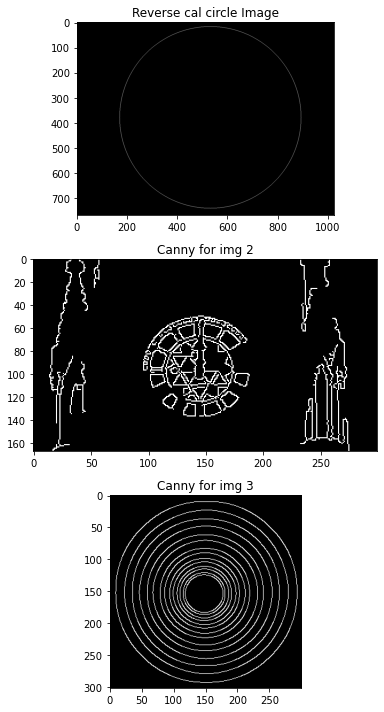

In [11]:


imgName = "circle.jpg"
img = cv.imread(imgName)
img2 = cv.imread("parliament_clock.jpg")
img3 = cv.imread("concentric_circles.jpg")

imgSize = [img.shape[0],img.shape[1]]
points = []
circle = []

imgEmpty = np.zeros((imgSize[0],imgSize[1]),dtype=np.uint8)
imgEdge = EdgeExtraction(CannyPara[0],CannyPara[1],img)
vaildPoints = ObtainValidPoints(imgEdge,imgSize)
points = RandomPointsGenerate(vaildPoints,imgSize)
circle = CircleCalculation(points)
print("center",[circle[0],circle[1]])
print("radius",circle[2])

plt.figure(dpi=300)
plt.figure(figsize=(10,10))
cv.circle(imgEmpty,(circle[1],circle[0]),circle[2],(255,255,255),RANSACe1)
plt.subplot(3,1,1)
plt.imshow(imgEmpty, cmap="gray")
plt.title("Reverse cal circle Image")

plt.subplot(3,1,2)
imgEdge = EdgeExtraction(CannyPara[0],CannyPara[1],img2)
plt.imshow(imgEdge, cmap="gray")
plt.title("Canny for img 2")

plt.subplot(3,1,3)
imgEdge = EdgeExtraction(CannyPara[0],CannyPara[1],img3)
plt.imshow(imgEdge, cmap="gray")
plt.title("Canny for img 3")

plt.tight_layout()

1.3

In [12]:
def RANSACAlgorithm(imgEdge,imgSize):
    #Required init 
    iteratNum = 0
    maxCountNum = -1
    bestCircle = (0,0,0)
    bestRatio = 0
    validPoints = ObtainValidPoints(imgEdge,imgSize)
    #Custom Init
    donePoints = []
    

    while iteratNum < RANSACIterationN:



        #obtain param
        k = 0
        ratio = 0
        points = RandomPointsGenerate(validPoints,imgSize)
        
        while points in donePoints:
            print("\nFind Repeated Point")
            iteratNum += 1
            points = RandomPointsGenerate(validPoints,imgSize)
        donePoints.append(points)
        
        tempCirclePara = CircleCalculation(points)
        k,ratio = CountComparePixels(imgEdge, tempCirclePara,imgSize)
        iteratNum += 1
        #try

        #check update
        if ratio > bestRatio and k > maxCountNum:
            print("\n"+10*'!',"UPDATE",10*'!')
            bestCircle = tempCirclePara
            maxCountNum = k
            bestRatio = ratio
        
        if ratio > RANSACThresholdRatio:
            print("\n"+20*"*","Reach RANSEC Threshold, break loop",20*"*") 
            # print("k = ",maxCountNum)
            print("ratio = ",ratio)
            print("circle = ",bestCircle)
            break
        
        #Performance
        pctge = iteratNum / RANSACIterationN
        temp = int(round(pBarLength * pctge))
        print('\r'+(temp)*'█'+(pBarLength-temp)*'░'+str(round(pctge*100))+'%'+"\tIteration = "+str(iteratNum)+"   \tBest: "+str(bestCircle)+"\tRatio ="+str(round(bestRatio,5)),end=' ')
    
    return bestCircle
    

In [13]:
def CountComparePixels(imgEdge,tempCirclePara,imgSize):
    k = 0
    ratio = 0
    tempCircle = np.zeros((imgSize[0],imgSize[1]),dtype=np.uint8)
    cv.circle(tempCircle,(tempCirclePara[1],tempCirclePara[0]),tempCirclePara[2],(255,255,255),RANSACe1)
    
    for x in range(imgSize[0]):
        for y in range(imgSize[1]):
            if tempCircle[x,y] == 255:
                ratio += 1
            if imgEdge[x,y] == 255 and tempCircle[x,y] == 255:
                k += 1
    try:
        ratio = k / ratio
        return k,ratio
    except:
        print("\nRatio Error")
        print("Circle para:",tempCirclePara)
        return 0,0

In [14]:
def PostProcessing(validCirclePoint):
    
    meanCenter = np.mean(validCirclePoint,axis=0)
    meanRadius = []
    for point in validCirclePoint:
        meanRadius.append(PointDistanceCal(point,meanCenter))
    meanRadius = np.mean(meanRadius,axis=0)

    return (int(meanCenter[0]),int(meanCenter[1]),int(meanRadius))


In [15]:


def RANSACMain(imgName):
    print("\nSTART RANSAC for image",imgName)

    img = cv.imread(imgName)
    imgSize = [img.shape[0],img.shape[1]]
    #filter out all valid point index
    imgEmpty = np.zeros((imgSize[0],imgSize[1]),dtype=np.uint8)
    imgEdge = EdgeExtraction(CannyPara[0],CannyPara[1],img)
    bestCircle = RANSACAlgorithm(imgEdge,imgSize)
    cv.circle(img,(bestCircle[1],bestCircle[0]),bestCircle[2],(0,0,255),RANSACe1)

    #1.4 PostProcessing 
    print("\n Finish RANSAC, Start Post Processing")
    validCirclePoint = []
    tempImg = np.zeros((imgSize[0],imgSize[1]),dtype=np.uint8)

    cv.circle(tempImg,(bestCircle[1],bestCircle[0]),bestCircle[2],(255,255,255),RANSACe1)
    try:
        validCirclePoint = ObtainValidPoints(tempImg,imgSize)
        bestCircle = PostProcessing(validCirclePoint)
    except:
        cv.imshow("Error",tempImg)
        print("v",validCirclePoint)
        print("b",bestCircle)


    #plot real image
    cv.circle(img,(bestCircle[1],bestCircle[0]),bestCircle[2],(0,255,0),RANSACe1)

    plt.figure(dpi=300)
    plt.figure(figsize=(10,10))

    plt.subplot(2,1,1)
    plt.imshow(cv.cvtColor(imgEdge,cv.COLOR_BGR2RGB))
    plt.title("Canny Image")
    plt.subplot(2,1,2)
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.title("RANSAC Circle")

    plt.tight_layout()





START RANSAC for image parliament_clock.jpg

!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░1%	Iteration = 54   	Best: [124, 92, 69]	Ratio =0.1637 
!!!!!!!!!! UPDATE !!!!!!!!!!
█████████░░░░░░░░░░░░░░░░░░░░░30%	Iteration = 3047   	Best: [89, 159, 33]	Ratio =0.35326 
!!!!!!!!!! UPDATE !!!!!!!!!!
████████████████████████░░░░░░78%	Iteration = 7840   	Best: [89, 135, 36]	Ratio =0.36 
!!!!!!!!!! UPDATE !!!!!!!!!!
██████████████████████████████100%	Iteration = 10000   	Best: [95, 144, 30]	Ratio =0.47024 
 Finish RANSAC, Start Post Processing

START RANSAC for image concentric_circles.jpg

!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 6   	Best: [93, 80, 52]	Ratio =0.16781 
!!!!!!!!!! UPDATE !!!!!!!!!!
█░░░░░░░░░░░░░░░░░░░░░░░░░░░░░2%	Iteration = 172   	Best: [174, 139, 48]	Ratio =0.22761 
!!!!!!!!!! UPDATE !!!!!!!!!!
███░░░░░░░░░░░░░░░░░░░░░░░░░░░9%	Iteration = 852   	Best: [174, 137, 47]	Ratio =0.24242 
!!!!!!!!!! UPDATE !!!!!!!!!!
████████░░░░░░░░░░

<Figure size 1800x1200 with 0 Axes>

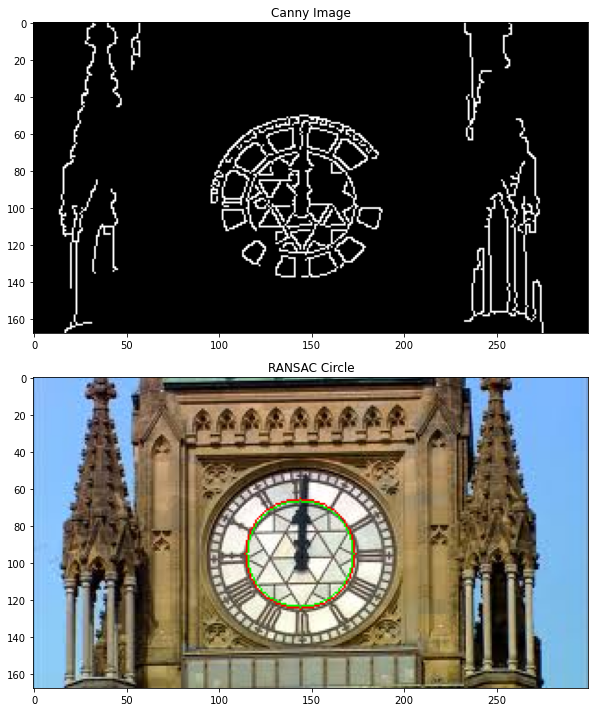

<Figure size 1800x1200 with 0 Axes>

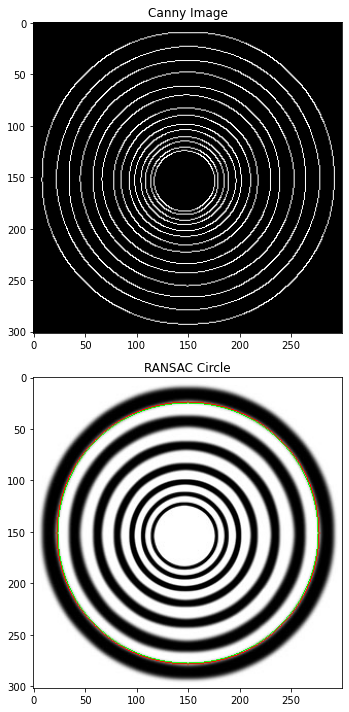

In [16]:

RANSACMain("parliament_clock.jpg")
RANSACMain("concentric_circles.jpg")